# Verkehrsmittelwahl

### Dataset

https://www.data.gv.at/katalog/dataset/7d610a57-2105-4dd7-9bc8-c4101ef42539#additional-info

- Vienna aggregated
- 2005-2022

= Share of traffic for different modes of transport:
- BICYCLE
- BY_FOOT
- CAR 
- MOTORCYCLE
- PUBLIC_TRANSPORT

## Prepare Data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
vmw_raw = pd.read_csv("../data_arima_raw/verkehrsmittelwahl2022.csv", sep=";")

cols_to_keep = ['YEAR', 'BICYCLE', 'BIKESHARING', 'BY_FOOT', 'CAR', 'CARSHARING', 'MOTORBIKE', 'PUBLIC_TRANSPORT']
vmw = vmw_raw[cols_to_keep].copy()

vmw['date'] = pd.to_datetime(vmw['YEAR'].astype(str) + '-01-01')
vmw = vmw.set_index('date').drop(columns=['YEAR'])

# Apply conversion to each percentage column
for col in vmw.columns:
    vmw[col] = vmw[col].str.replace(",", ".").astype(float)

vmw = vmw.asfreq("YS")

## Forecast

In [4]:
# FORECAST 2023–2030 FOR EACH MODE-SHARE AT ANNUAL FREQUENCY

# Build an empty DataFrame spanning 2005–2030 (annual index)
years_full = pd.date_range("2005-01-01", "2030-01-01", freq="YS")
vmw_full    = pd.DataFrame(index=years_full, columns=vmw.columns)

# Copy historic values (2005–2022) into vmw_full
vmw_full.loc[vmw.index, :] = vmw.values

# For each mode, fit ARIMA(1,1,1) on 2005–2022 and forecast 8 years
n_fore = 8
for mode in vmw.columns:
    series = vmw[mode]                   # index.freq == "YS"
    model  = ARIMA(series, order=(1, 1, 1))
    fitted = model.fit()
    f_idx  = pd.date_range("2023-01-01", periods=n_fore, freq="YS")
    vmw_full.loc[f_idx, mode] = fitted.forecast(steps=n_fore).values

# Renormalize each year so the seven shares sum to exactly 100
vmw_full = vmw_full.div(vmw_full.sum(axis=1), axis=0) * 100

c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Final Adjustments

In [5]:
vmw_full = vmw_full.astype(float)

vmw_monthly = vmw_full.resample("ME").ffill()

all_month_ends = pd.date_range("2005-01-31", "2030-12-31", freq="ME")

vmw_monthly = vmw_monthly.reindex(all_month_ends).ffill()

print(vmw_monthly.index.min())  # → 2005-01-31
print(vmw_monthly.index.max())  # → 2030-12-31

vmw_monthly.index = vmw_monthly.index.to_period("M").to_timestamp()

vmw_monthly = vmw_monthly.clip(lower=0)

vmw_decimal = vmw_monthly.copy()
vmw_decimal = vmw_decimal / 100.0

vmw_decimal['sum_of_shares'] = vmw_decimal.sum(axis=1)

2005-01-31 00:00:00
2030-12-31 00:00:00


In [6]:
vmw_decimal.tail()

,BICYCLE,BIKESHARING,BY_FOOT,CAR,CARSHARING,MOTORBIKE,PUBLIC_TRANSPORT,sum_of_shares
2030-08-01,0.094333,0.0,0.361491,0.226712,0.000593,0.004974,0.311898,1.0
2030-09-01,0.094333,0.0,0.361491,0.226712,0.000593,0.004974,0.311898,1.0
2030-10-01,0.094333,0.0,0.361491,0.226712,0.000593,0.004974,0.311898,1.0
2030-11-01,0.094333,0.0,0.361491,0.226712,0.000593,0.004974,0.311898,1.0
2030-12-01,0.094333,0.0,0.361491,0.226712,0.000593,0.004974,0.311898,1.0


In [7]:
vmw_final = vmw_decimal.drop(columns=["sum_of_shares"])

output_path = "../data_arima_final/verkehrsmittelwahl.csv"
vmw_final.to_csv(output_path, index=True)

#### Plot

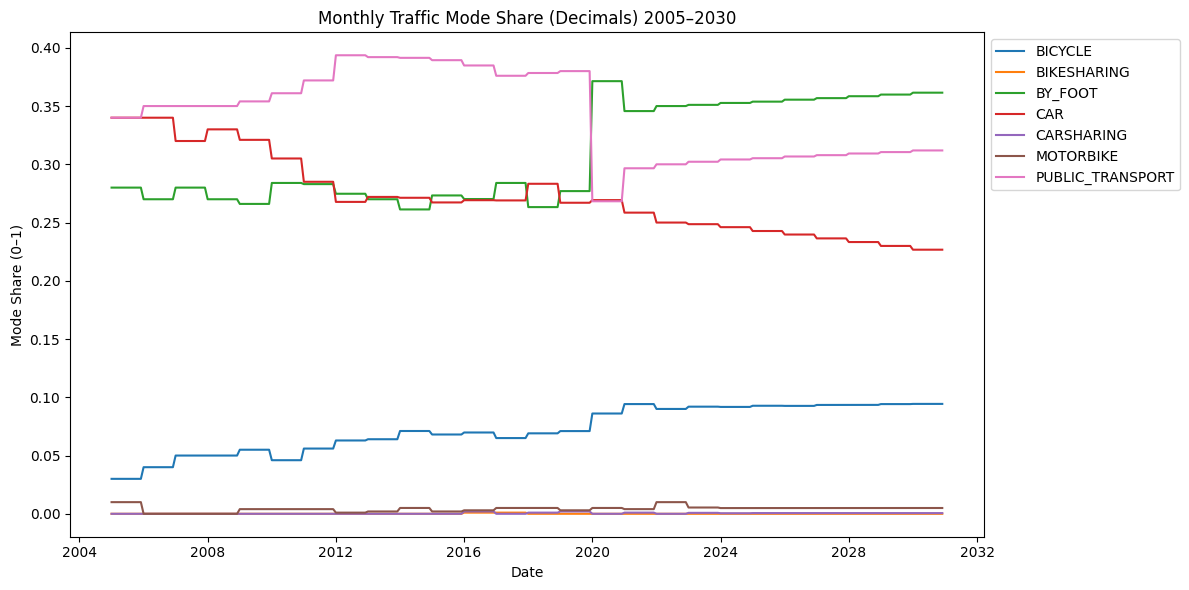

: 

In [ ]:
plt.figure(figsize=(12, 6))
for col in vmw_decimal.columns.drop("sum_of_shares"):
    plt.plot(vmw_decimal.index, vmw_decimal[col], label=col)

plt.title("Monthly Traffic Mode Share (Decimals) 2005–2030")
plt.xlabel("Date")
plt.ylabel("Mode Share (0–1)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()